In [1]:
from sectional_v2.constants import get_plotpath
from sectional_v2.util.practical_functions import make_folders
from IPython.display import clear_output

/home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV/


In [2]:
from sectional_v2.util.plot.plot_maps import plot_map_diff, fix_axis4map_plot, plot_map_abs_abs_diff, plot_map,plot_map_diff_only
from useful_scit.imps import (np, xr, plt, pd) 
from sectional_v2.util.imports import get_averaged_fields
from sectional_v2.util.plot.plot_profiles import plot_profile, set_legend_area_profs, set_scalar_formatter

# load and autoreload
from useful_scit.plot import get_cmap_dic
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

/home/ubuntu/mnts/nird/projects/OAS-DEV/sectional_v2/data_info/area_defs.csv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from matplotlib import gridspec

In [4]:
from useful_scit.plot.fig_manip import subp_insert_abc

In [5]:
plot_path = get_plotpath('comparison')
print(plot_path)
make_folders(plot_path)
fn_base = plot_path + '/prof_map_'
print(fn_base)

/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/global_comparison/
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/global_comparison//prof_map_


In [6]:
model = 'NorESM'

startyear = '2008-01'
endyear = '2014-12'
pmin = 850.  # minimum pressure level
avg_over_lev = True  # True#True#False#True
pressure_adjust = True  # Can only be false if avg_over_lev false. Plots particular hybrid sigma lev
if avg_over_lev:
    pressure_adjust = True
p_levels = [1013.,900., 800., 700., 600.]  # used if not avg

In [7]:
cases_sec = ['SECTv21_ctrl_koagD'] #'SECTv21_ctrl_def',
cases_orig =['noSECTv21_default_dd','noSECTv21_ox_ricc_dd']
#cases_orig =['noSECTv21_ox_ricc']

cases = cases_orig + cases_sec

## Combined plots

In [8]:
import cartopy.crs as ccrs

## N_AER

## H2SO4

In [9]:
from sectional_v2.util.plot.colors import get_area_col
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from sectional_v2.data_info import get_nice_name_case

In [10]:
linests = ['solid','-.',':'][::-1] #,'dashed'

In [11]:
areas = ['Global','notLand','landOnly']#, 'Polar N']#,'Polar S']
areas = ['Global','Polar S','Amazonas and surroundings']

In [12]:
from sectional_v2.util.slice_average.significance import hatch_area_sign, calc_sign_over_fields
from sectional_v2.util.slice_average.avg_pkg import yearly_mean_dic

eee


In [13]:
import seaborn as sns

SOA_NA='SOA_NA'
SO4_NA='SO4_NA'
def get_frac(case_dic):
    for case in case_dic.keys():
        ds = case_dic[case]
        tot =ds[SO4_NA] + ds[SOA_NA]
        fSOA = ds[SOA_NA]/tot*100
        fSO4 = ds[SO4_NA]/tot*100
        case_dic[case]['fSOA'] =fSOA
        case_dic[case]['fSO4'] =fSO4
        case_dic[case]['fSOA'].attrs['units'] ='%'
        case_dic[case]['fSO4'].attrs['units'] ='%'


def map_sub(ax3, cases, relative, var, var_map, varl,kwargs_diff=None):
    if var_map is not None:
        var = var_map
    maps_dic = get_averaged_fields.get_maps_cases(cases, varl, startyear, endyear,
                                                  avg_over_lev=avg_over_lev,
                                                  pmin=pmin,
                                                  pressure_adjust=pressure_adjust)
    get_frac(maps_dic)
    plot_map_diff_only(var, cases, maps_dic, relative=relative, cbar_equal=True,
                       kwargs_diff=kwargs_diff, axs=ax3, cmap_diff='RdBu_r',
                       cbar_loc='under', tight_layout=False)


def profiles_sub(areas, ax1, cases, linestd, linestd_nn, var, varl):
    for case, ls in zip(cases, linests):
        linestd[case] = ls
        linestd_nn[get_nice_name_case(case)] = ls
    ax = ax1  # plt.subplots(1, figsize=[6,8])
    for area in areas:
        prof_dic = get_averaged_fields.get_profiles(cases, varl, startyear, endyear, area=area,
                                                    pressure_adjust=pressure_adjust)

        get_frac(prof_dic)
        for case in cases:
            kwargs = dict(color=get_area_col(area), linestyle=linestd[case])
            plot_profile(prof_dic[case][var],
                         ax=ax,
                         kwargs=kwargs,
                         xscale='linear',
                         label=case + ', ' + area,
                         ylim=[1000, 200])  # ,
    ax.grid(False, which='both')
    sns.despine(ax=ax)
    #ax.set_yscale('log')
    set_scalar_formatter(ax)
    

def hatch_sign(case_sec, from_cases, axs_maps, var1, varl, startyear, endyear, pressure_adjust=pressure_adjust,
                       avg_over_lev=avg_over_lev,
                       ci=.95,
                       groupby=None,
                       dims=('lev',),
                       area='Global',
                       avg_dim='time',
                       hatches=None, hatch_lw = .4, transform=ccrs.PlateCarree(),
                       reverse=False):
    dic_means_yr = yearly_mean_dic(varl, [case_sec,*from_cases], startyear, endyear, pmin, pressure_adjust,
                                   avg_over_lev=avg_over_lev, groupby=groupby, dims=dims, area=area)
    get_frac(dic_means_yr)
    for f_case, ax in zip(from_cases, axs_maps):
        case1=case_sec
        case2 = f_case
        da1 = dic_means_yr[case1][var1]
        da2 = dic_means_yr[case2][var1]
        data4comp = {case1: da1, case2: da2}
        D = da1 - da2
        data4comp[f'{case1}-{case2}'] = D.copy()

        T, sig_map, t = calc_sign_over_fields(da1, da2, avg_dim, ci)
        hatch_area_sign(t, T, ax, hatches=hatches, hatch_lw = hatch_lw, transform=transform, reverse=reverse)#, reverse=True)



Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_default_dd/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_default_dd/Global/SO4_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_ox_ricc_dd/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_ox_ricc_dd/Global/SO4_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/SECTv21_ctrl_koagD/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/SECTv21_ctrl_koagD/Global/SO4_NA_2008-01-2014-12.nc
Did not find profile mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_m

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find map mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_default_dd/SO4_NA_2008-01-2014-12_avg2lev850.nc or  /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_default_dd/SO4_NA_2008-01-2014-12_lev_not_dim.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_default_dd/SO4_NA_NorESM_noSECTv21_default_dd_2008-01-2014-12.nc
<xarray.Dataset>
Dimensions:  (lat: 96, lev: 32, lon: 144, time: 84)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
Data variables:
    SO4_NA   (time, lev, lat, lon) float64 dask.array<chunksize=(84, 32, 96, 144), meta=np.ndarray>
D

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find map mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SOA_NA_2008-01-2014-12_avg2lev850.nc or  /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SOA_NA_2008-01-2014-12_lev_not_dim.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/SECTv21_ctrl_koagD/SOA_NA_NorESM_SECTv21_ctrl_koagD_2008-01-2014-12.nc
<xarray.Dataset>
Dimensions:  (lat: 96, lev: 32, lon: 144, time: 84)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
Data variables:
    SOA_NA   (time, lev, lat, lon) float64 dask.array<chunksize=(84, 32, 96, 144), meta=np.ndarray>
Did not f

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find map mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SO4_NA_2008-01-2014-12_avg2lev850.nc or  /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SO4_NA_2008-01-2014-12_lev_not_dim.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/SECTv21_ctrl_koagD/SO4_NA_NorESM_SECTv21_ctrl_koagD_2008-01-2014-12.nc
<xarray.Dataset>
Dimensions:  (lat: 96, lev: 32, lon: 144, time: 84)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
Data variables:
    SO4_NA   (time, lev, lat, lon) float64 dask.array<chunksize=(84, 32, 96, 144), meta=np.ndarray>
Did not f

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


['SECTv21_ctrl_koagD']


/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find map mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_ox_ricc_dd/SOA_NA_2008-01-2014-12_avg2lev850.nc or  /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_ox_ricc_dd/SOA_NA_2008-01-2014-12_lev_not_dim.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_ox_ricc_dd/SOA_NA_NorESM_noSECTv21_ox_ricc_dd_2008-01-2014-12.nc
<xarray.Dataset>
Dimensions:  (lat: 96, lev: 32, lon: 144, time: 84)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
Data variables:
    SOA_NA   (time, lev, lat, lon) float64 dask.array<chunksize=(84, 32, 96, 144), meta=np.ndarray>
D

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find map mean with filename: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_ox_ricc_dd/SO4_NA_2008-01-2014-12_avg2lev850.nc or  /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/noSECTv21_ox_ricc_dd/SO4_NA_2008-01-2014-12_lev_not_dim.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_ox_ricc_dd/SO4_NA_NorESM_noSECTv21_ox_ricc_dd_2008-01-2014-12.nc
<xarray.Dataset>
Dimensions:  (lat: 96, lev: 32, lon: 144, time: 84)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
Data variables:
    SO4_NA   (time, lev, lat, lon) float64 dask.array<chunksize=(84, 32, 96, 144), meta=np.ndarray>
D

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SOA_NA_2008-01-2014-12_avg2lev850.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/map_means//NorESM/SECTv21_ctrl_koagD/SO4_NA_2008-01-2014-12_avg2lev850.nc
['SECTv21_ctrl_koagD']


/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/SECTv21_ctrl_koagD/SOA_NA_NorESM_SECTv21_ctrl_koagD_2008-01-2014-12.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/SECTv21_ctrl_koagD/SO4_NA_NorESM_SECTv21_ctrl_koagD_2008-01-2014-12.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_default_dd/SOA_NA_NorESM_noSECTv21_default_dd_2008-01-2014-12.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_default_dd/SO4_NA_NorESM_noSECTv21_default_dd_2008-01-2014-12.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_ox_ricc_dd/SOA_NA_NorESM_noSECTv21_ox_ricc_dd_2008-01-2014-12.nc
Loading file: /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//Fields_pressure_coordinates/NorESM/noSECTv21_ox_ri

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/persistent01/miniconda3

/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/global_comparison//prof_map_fSOA_2008-01-2014-12_noSECTv21_default_dd_noSECTv21_ox_ricc_dd_SECTv21_ctrl_koagD.


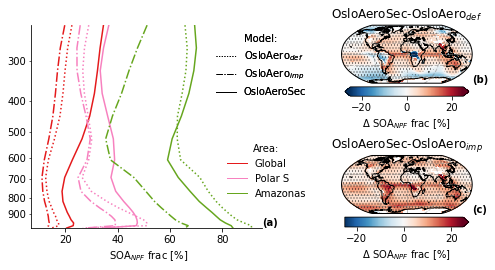

In [14]:
asp_rat=.55
#width=6.8
width_ratios=[3, .3,1.7]
#width_ratios=[3, .6,1.8]
width=7.0
relative=False
varl_map=None
nvars=1
fig = plt.figure(figsize = [width*nvars,asp_rat*width*nvars])
gs = gridspec.GridSpec(2, nvars+2,  width_ratios=width_ratios)
axs_prof = []
axs_maps = []
ax1 = plt.subplot(gs[:,0])
ax_labs = plt.subplot(gs[:,1])
ax_maps1 = plt.subplot(gs[0,2], projection=ccrs.Robinson())
ax_maps2 = plt.subplot(gs[1,2], projection=ccrs.Robinson())
var1 = 'fSOA'

linestd=dict()
linestd_nn=dict()
varl = ['SOA_NA','SO4_NA']

profiles_sub(areas, ax1, cases, linestd, linestd_nn, var1, varl)
linestd=dict()
linestd_nn=dict()
for case, ls in zip(cases, linests):
    linestd[case]=ls
    linestd_nn[get_nice_name_case(case)]=ls
ax =ax1# plt.subplots(1, figsize=[6,8])
cases_nn = [get_nice_name_case(case) for case in cases]
ax_labs.axis('off')

set_legend_area_profs(ax_labs, areas,cases_nn, linestd_nn)


ax1.yaxis.set_ticklabels([])
ax1.set_ylabel('')
# maps:
kwargs_diff=dict(vmin=-25, vmax=25)
map_sub(ax_maps1, [cases_orig[0],cases_sec[0]], relative, var1, None, varl, kwargs_diff=kwargs_diff)
map_sub(ax_maps2, [cases_orig[1],cases_sec[0]], relative, var1, None, varl, kwargs_diff=kwargs_diff)
ax_maps1.set_title(f'{get_nice_name_case(cases_sec[0])}-{get_nice_name_case(cases_orig[0])}')
ax_maps2.set_title(f'{get_nice_name_case(cases_sec[0])}-{get_nice_name_case(cases_orig[1])}')

hatch_sign(cases_sec[0], cases_orig[:2], [ax_maps1, ax_maps2], var1, varl, startyear, endyear, pressure_adjust=pressure_adjust,
                       avg_over_lev=avg_over_lev,
                       ci=.95,
                       groupby=None,
                       dims=('lev',),
                       area='Global',
                       avg_dim='time',
                       hatches=None, hatch_lw = .4, 
                       transform=ccrs.PlateCarree(),
                       reverse=False)

axs_np = np.array([ax1,ax_maps1, ax_maps2])
    
subp_insert_abc(axs_np, pos_y =.01, pos_x=1)

vars_n = var1
fn_figure = '%s%s_%s-%s_%s.'%(fn_base,vars_n,startyear, endyear,'_'.join(cases))
print(fn_figure)
plt.tight_layout()
#axs_prof[0].set_xlim([1e-13,5e-11])
#axs_prof[1].set_xlim([1e-13,5e-11])
plt.savefig(fn_figure + 'png')
plt.savefig(fn_figure + 'pdf', dpi=300)

plt.show()

Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_default_dd/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_default_dd/Global/SO4_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_ox_ricc_dd/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_ox_ricc_dd/Global/SO4_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/SECTv21_ctrl_koagD/Global/SOA_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/SECTv21_ctrl_koagD/Global/SO4_NA_2008-01-2014-12.nc
Loading file /home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV//means/profile_means//NorESM/noSECTv21_defau

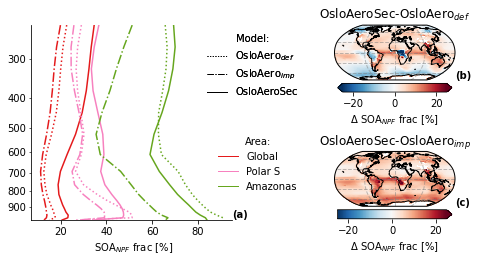

In [15]:
asp_rat=.55
width=6.8
relative=False
varl_map=None
nvars=1
fig = plt.figure(figsize = [width*nvars,asp_rat*width*nvars])
gs = gridspec.GridSpec(2, nvars+2,  width_ratios=[3, .6,1.8])
axs_prof = []
axs_maps = []
ax1 = plt.subplot(gs[:,0])
ax_labs = plt.subplot(gs[:,1])
ax_maps1 = plt.subplot(gs[0,2], projection=ccrs.Robinson())
ax_maps2 = plt.subplot(gs[1,2], projection=ccrs.Robinson())
var1 = 'fSOA'

linestd=dict()
linestd_nn=dict()
varl = ['SOA_NA','SO4_NA']

profiles_sub(areas, ax1, cases, linestd, linestd_nn, var1, varl)
linestd=dict()
linestd_nn=dict()
for case, ls in zip(cases, linests):
    linestd[case]=ls
    linestd_nn[get_nice_name_case(case)]=ls
ax =ax1# plt.subplots(1, figsize=[6,8])
cases_nn = [get_nice_name_case(case) for case in cases]
ax_labs.axis('off')

set_legend_area_profs(ax_labs, areas,cases_nn, linestd_nn)


ax1.yaxis.set_ticklabels([])
ax1.set_ylabel('')
# maps:
kwargs_diff=dict(vmin=-25, vmax=25)
map_sub(ax_maps1, [cases_orig[0],cases_sec[0]], relative, var1, None, varl, kwargs_diff=kwargs_diff)
map_sub(ax_maps2, [cases_orig[1],cases_sec[0]], relative, var1, None, varl, kwargs_diff=kwargs_diff)
ax_maps1.set_title(f'{get_nice_name_case(cases_sec[0])}-{get_nice_name_case(cases_orig[0])}')
ax_maps2.set_title(f'{get_nice_name_case(cases_sec[0])}-{get_nice_name_case(cases_orig[1])}')


axs_np = np.array([ax1,ax_maps1, ax_maps2])
    
subp_insert_abc(axs_np, pos_y =.01, pos_x=1)

vars_n = var1
fn_figure = '%s%s_%s-%s_%s.'%(fn_base,vars_n,startyear, endyear,'_'.join(cases))
print(fn_figure)
plt.tight_layout()
#axs_prof[0].set_xlim([1e-13,5e-11])
#axs_prof[1].set_xlim([1e-13,5e-11])
#plt.savefig(fn_figure + 'png')
#plt.savefig(fn_figure + 'pdf', dpi=300)

plt.show()